In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy


import sscCdi
sscCdi.__version__

'0.8.10'

(0.05, 0.95, 20.0, (400, 2), (400, 2048, 2048))

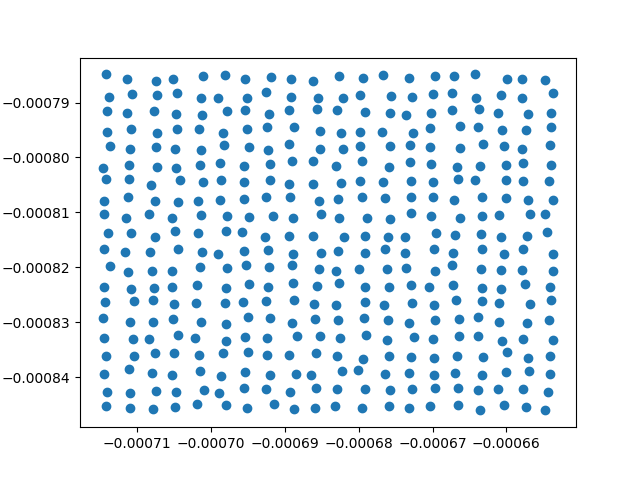

In [2]:
# SIEMENS BIG FOV
path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_50_z1z2_1000_032.hdf5'
z1 = 50*1e-3

# SIEMENS SMAL FOV
# path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_5_z1z2_1000_com_flat_dark_22_e_39kev_045.hdf5'
# z1 = 5e-3

# path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_golgi/raw/ptycho_amostra_murilo_z1_500_z1z2_1000_com_flat_dark_22_e_39kev_005.hdf5'
# z1 = 500e-3


z2 = 1 - z1
M = (z2+z1)/z1


data = h5py.File(path, 'r')
DPs = data['scan/detector/data'][()]

positions = data['scan/detector/positions'][()][:,0:2]

positions0 = positions*1e-3

fig, ax = plt.subplots()
ax.plot(positions0[:,1],positions0[:,0],'o')

z1, z2, M, positions0.shape, DPs.shape

In [3]:
c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_distance": z2/M, # meter
"distance": z2/M, # meter
"detector_pixel_size": 1.44e-6/M,
"source_distance": 0, # should be 0 if parallel beam
}

wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength

inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')

Object pixel = 7.2e-08 m


Probe shape = (2048, 2048)
Deleting 200 slices
Size of the array: 1.5625 GB
Object shape = (3296, 3298)
Data shape = (200, 2048, 2048)
Positions shape = (200, 2)


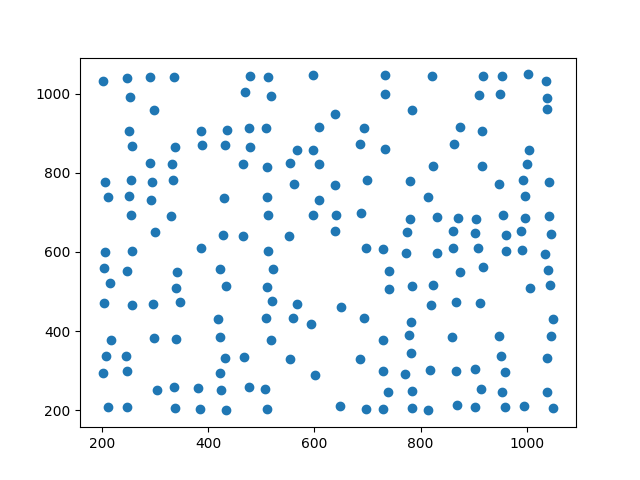

In [4]:
# empty = data['scan/detector/flats'][()][0]
empty = np.ones_like(DPs[0])

probe = np.ones_like(empty)

print(f'Probe shape = {probe.shape}')

inputs["object_padding"] = 200
positions0 = sscCdi.convert_probe_mogno_positions_meters_to_pixels(positions0.copy(),inputs["object_pixel"],inputs["object_padding"])

if 1: # remove random points from data
    n_of_points_to_keep = 200
    start_idx = positions0.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions0.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    DPs = np.delete(DPs,slices_to_ignore,axis=0)
    positions = np.delete(positions0,slices_to_ignore,axis=0)

fig, ax = plt.subplots()
ax.plot(positions[:,0],positions[:,1],'o')

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

inputs = sscCdi.set_object_shape(inputs, DPs.shape, positions)
inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')

print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

In [5]:
%matplotlib widget
sscCdi.misc.deploy_visualizer(DPs,type='abs',title='CC',cmap='gray',axis=0) # select axis

In [6]:
model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
obj_guess = np.ones_like(model_object) # constant object

inputs['iterations'] = 10
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.01 # RAAR; small value to add to probe/object update denominator

inputs

{'n_cpus': 32,
 'energy': 22,
 'detector_distance': 0.0475,
 'distance': 0.0475,
 'detector_pixel_size': 7.2e-08,
 'source_distance': 0,
 'wavelength': 5.6356453357367875e-11,
 'object_pixel': 7.2e-08,
 'object_padding': 200,
 'object_shape': (3296, 3298),
 'iterations': 10,
 'fresnel_regime': True,
 'probe_support': None,
 'incoherent_modes': 1,
 'beta': 0.9,
 'epsilon': 0.01}

In [7]:
positions.shape, DPs.shape, probe_guess.shape, obj_guess.shape

((200, 2), (200, 2048, 2048), (2048, 2048), (3296, 3298))

In [8]:
# positions = np.roll(positions,shift=1,axis=1)
RAAR_obj, RAAR_probes, RAAR_error = sscCdi.ptycho.raar.RAAR_multiprobe_cupy(DPs,positions,obj_guess,probe_guess,inputs)

propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2/M,0) 
propagated_probe /= np.max(propagated_probe)

RAAR_obj.shape, RAAR_probes.shape

	Iteration 0/10 	Error: 1.89e-01
	Iteration 1/10 	Error: 3.67e-02
	Iteration 2/10 	Error: 6.07e-02
	Iteration 3/10 	Error: 8.83e-02
	Iteration 4/10 	Error: 1.13e-01
	Iteration 5/10 	Error: 1.35e-01
	Iteration 6/10 	Error: 1.55e-01
	Iteration 7/10 	Error: 1.73e-01
	Iteration 8/10 	Error: 1.88e-01
	Iteration 9/10 	Error: 2.01e-01


((3296, 3298), (1, 2048, 2048))

In [9]:
# fig, ax = plt.subplots(1,4,figsize=(10,5),dpi=100)
# ax[0].imshow(np.abs(obj_guess)), ax[0].set_title('Initial Obj Mag')
# ax[1].imshow(np.angle(obj_guess)), ax[1].set_title('Initial Obj Phase')
# ax[2].imshow(np.abs(probe_guess)), ax[2].set_title('Initial Probe Mag')
# ax[3].imshow(np.angle(probe_guess)), ax[3].set_title('Initial Probe Phase')

(<matplotlib.image.AxesImage at 0x7f233cf46df0>, Text(0.5, 1.0, 'Data[85]'))

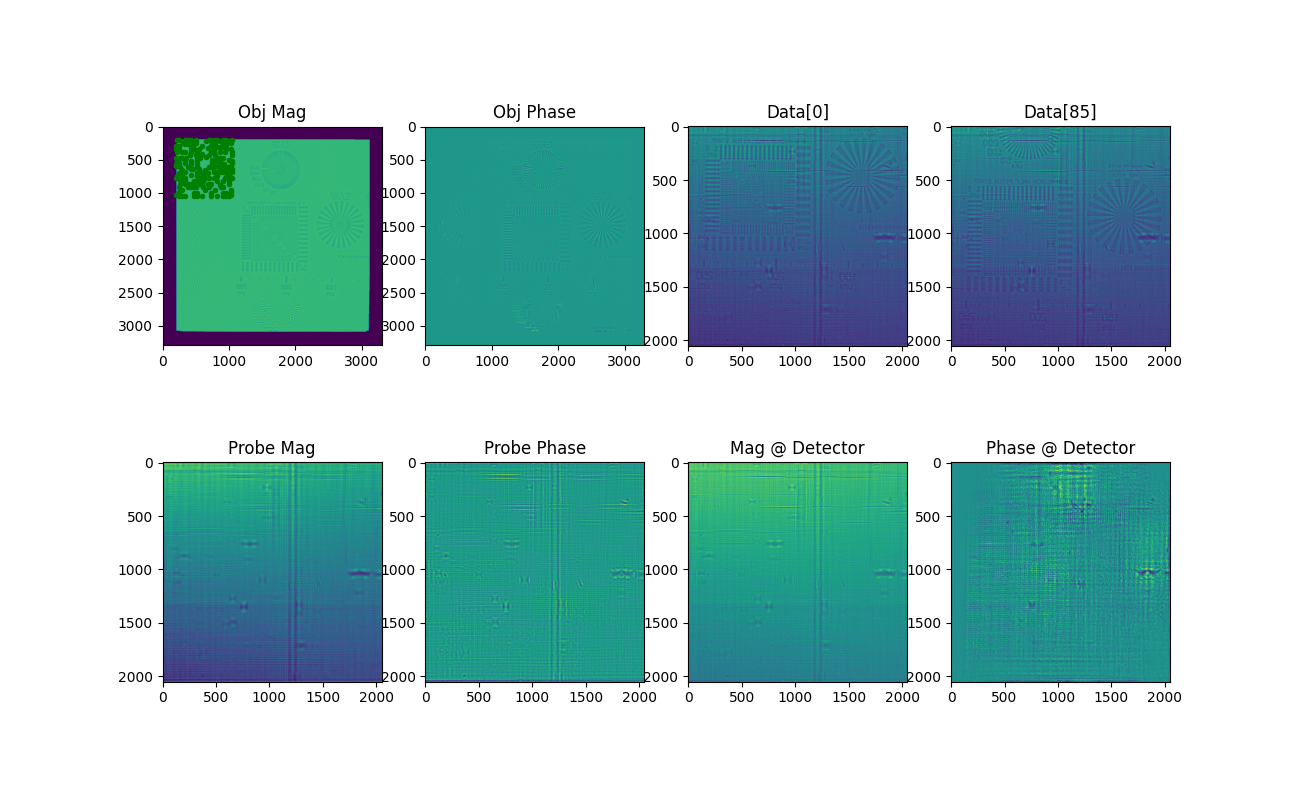

In [10]:
fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
ax[0,0].imshow(np.abs(RAAR_obj)), ax[0,0].set_title('Obj Mag')
# ax[0,0].plot(positions[:,1],positions[:,0],'.',color='r')
ax[0,0].plot(positions[:,0],positions[:,1],'.',color='g')
ax[0,1].imshow(np.angle(RAAR_obj)), ax[0,1].set_title('Obj Phase')
ax[0,2].imshow(np.abs(DPs[0])), ax[0,2].set_title('Data[0]')
ax[1,0].imshow(np.abs(RAAR_probes[0])), ax[1,0].set_title('Probe Mag')
ax[1,1].imshow(np.angle(RAAR_probes[0])), ax[1,1].set_title('Probe Phase')
ax[1,2].imshow(np.abs(propagated_probe)), ax[1,2].set_title('Mag @ Detector')
mean = np.mean(np.angle(propagated_probe))
std=np.std(np.angle(propagated_probe))
ax[1,3].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std), ax[1,3].set_title('Phase @ Detector')
ax[0,3].imshow(np.abs(DPs[85])), ax[0,3].set_title('Data[85]')
# ax[0,3].plot(RAAR_error,'o-',label='Error')
# ax[0,3].set_xlabel('Iterations')
# ax[0,3].legend(), ax[0,3].grid()

# fig.suptitle('Near Field Ptychography')

# for i, ax in enumerate(ax.ravel()):
#     if i==3 or i==0 or i ==4: continue
#     ax.set_xticks([])
#     ax.set_yticks([])

In [11]:
# np.save('RAARobj.npy',RAAR_obj)

In [16]:
distances = np.linspace(-1e-2,5e-2,100)

roi = RAAR_obj[2200:2600,2300:2700]

propagation = np.ones((distances.shape[0],roi.shape[0],roi.shape[1]),dtype=complex)

for i, z in enumerate(distances):
    propagated_roi = sscCdi.fresnel_propagator_cone_beam(roi.copy(),inputs["wavelength"],inputs["detector_pixel_size"],z,0) 
    propagation[i] = propagated_roi

sscCdi.deploy_visualizer(propagation,type='phase',cmap='viridis')

In [13]:
# fig, ax = plt.subplots(1,3,dpi=200)
# ax[0].imshow(DPs[0])

	Iteration 0/10 	Error: 4.04e+06


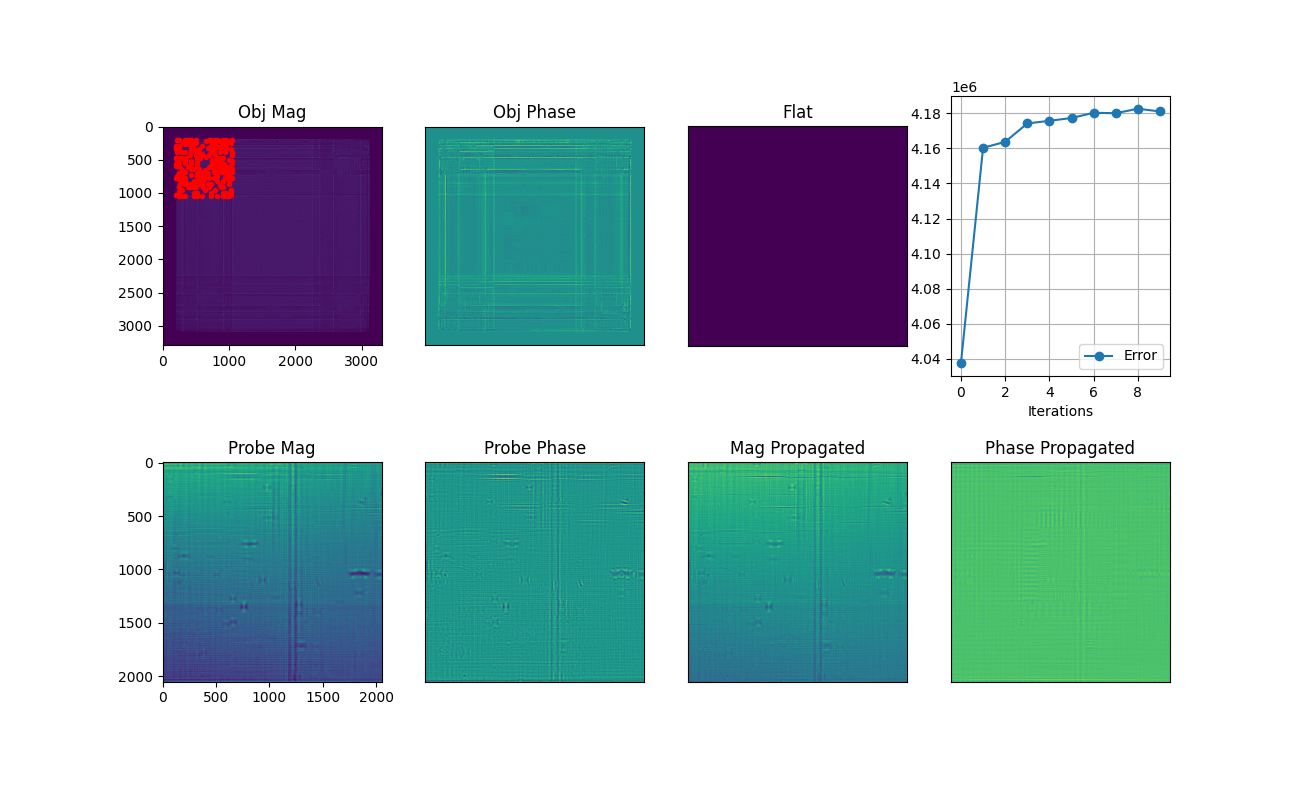

In [15]:
inputs["regularization_object"] = 0.25
inputs["regularization_probe"] = 0.5
inputs["step_object"] = 0.7
inputs["step_probe"] = 0.5

inputs["friction_object"] = 0.9
inputs["friction_probe"] = 0.99
inputs["momentum_counter"] = 10
inputs["use_mPIE"] = False
PIE_obj, PIE_probes, PIE_error = sscCdi.PIE_multiprobe_loop(DPs, positions,obj_guess,probe_guess,inputs)

propagated_probe_PIE = sscCdi.fresnel_propagator_cone_beam(PIE_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2/M,0) 

propagated_probe_PIE /= np.max(propagated_probe_PIE)

fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
ax[0,0].imshow(np.abs(PIE_obj[0])), ax[0,0].set_title('Obj Mag')
ax[0,0].plot(positions[:,0],positions[:,1],'.',color='r')
ax[0,1].imshow(np.angle(PIE_obj[0])), ax[0,1].set_title('Obj Phase')
ax[0,2].imshow(np.abs(empty),vmax=6000), ax[0,2].set_title('Flat')
ax[1,0].imshow(np.abs(PIE_probes[0])), ax[1,0].set_title('Probe Mag')
ax[1,1].imshow(np.angle(PIE_probes[0])), ax[1,1].set_title('Probe Phase')
ax[1,2].imshow(np.abs(propagated_probe_PIE)), ax[1,2].set_title('Mag Propagated')
ax[1,3].imshow(np.angle(propagated_probe_PIE)), ax[1,3].set_title('Phase Propagated')
ax[0,3].plot(PIE_error,'o-',label='Error')
ax[0,3].set_xlabel('Iterations')
ax[0,3].legend(), ax[0,3].grid()

for i, ax in enumerate(ax.ravel()):
    if i==3 or i==0 or i ==4: continue
    ax.set_xticks([])
    ax.set_yticks([])